# Training Material: Time-Series Analysis of AOI Regions with ALOS-2 Data

## I. Prerequisites

### Introduction to Relevant Libraries

In [1]:
!pip install rasterio matplotlib gdal numpy geopandas


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


## II: Working with ALOS-2 Data in Python for a time-series profile

### Loading ALOS-2 Data

ALOS-2 data is often provided in GeoTIFF format, a standard format for georeferenced raster data.

In [2]:
import os
import rasterio
import numpy as np

# Specify the folder containing ALOS-2 images
folder_path = "/home/jovyan/shared/genAI/3_sirin/preprocessed"

# List all GeoTIFF files in the folder
image_paths = [
    os.path.join(folder_path, file)
    for file in os.listdir(folder_path)
    if file.endswith(".tif")  # Filter only GeoTIFF files
]

# Sort the file paths (optional, ensures consistent stacking order)
image_paths.sort()

# Open the images
images = [rasterio.open(img) for img in image_paths]

# Print file names to verify
print(f"Loaded images: {image_paths}")


Loaded images: ['/home/jovyan/shared/genAI/3_sirin/preprocessed/HH-191127_filtered.tif', '/home/jovyan/shared/genAI/3_sirin/preprocessed/HH-200304_filtered.tif', '/home/jovyan/shared/genAI/3_sirin/preprocessed/HH-200610_filtered.tif', '/home/jovyan/shared/genAI/3_sirin/preprocessed/HH-210303_filtered.tif', '/home/jovyan/shared/genAI/3_sirin/preprocessed/HH-210609_filtered.tif', '/home/jovyan/shared/genAI/3_sirin/preprocessed/HH-211124_filtered.tif', '/home/jovyan/shared/genAI/3_sirin/preprocessed/HH-220302_filtered.tif']


## Stack Layers

Stacking layers from multiple images into a 3D NumPy array.

In [3]:
# Stack the layers from multiple images
stacked_data = np.stack([img.read(1) for img in images], axis=0)
print("Image layers stacked successfully.")


Image layers stacked successfully.


### Calculate the median backscatter coefficient for each AOI.

- Specify the file paths for the ALOS-2 stacked images and the AOI (Area of Interest) file (create your own AOI file or download it in the cell below
- Define the years corresponding to each band in the stacked image, and create simulated time points.ime

In [4]:
!curl --output aoi_toyota.gpkg "https://owncloud.glodal-inc.net/owncloud/index.php/s/xPdaXgH00OwQKFQ/download"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 98304  100 98304    0     0   205k      0 --:--:-- --:--:-- --:--:--  205k


### Plot Time-Series Graph

Plots the computed median backscatter values as a time-series graph

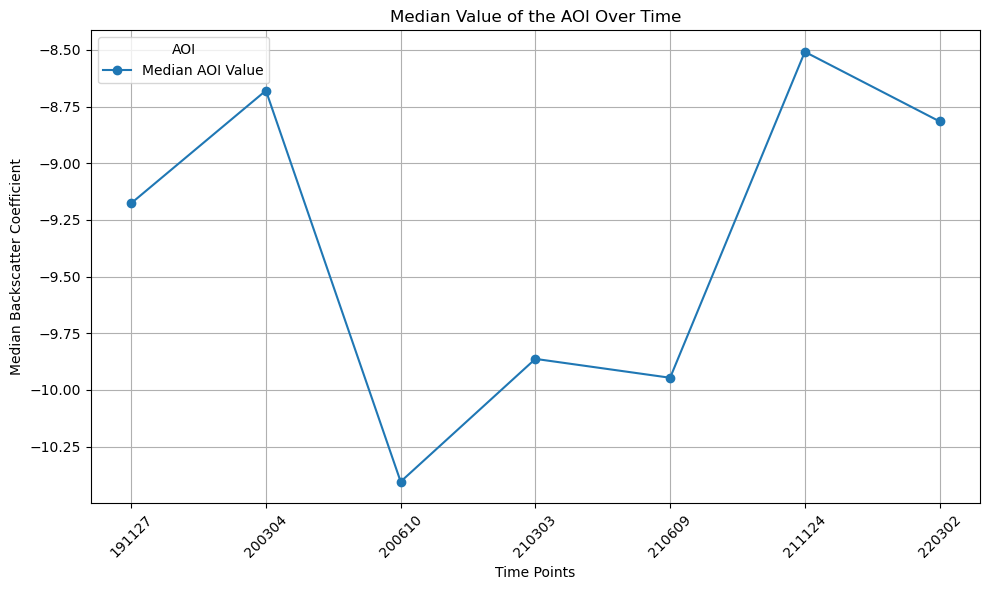

In [7]:
import rasterio.features  # Import features explicitly
import matplotlib.pyplot as plt
import geopandas as gpd

# Load the AOI geometry using geopandas
aoi_gdf = gpd.read_file('aoi_toyota.gpkg')

# Use the transform and spatial shape from one of the images in the stack
transform = images[0].transform
height, width = stacked_data.shape[1], stacked_data.shape[2]  # Spatial dimensions of the stack

# Initialize an empty mask for the entire AOI
combined_mask = np.zeros((height, width), dtype=bool)

# Combine masks for all valid geometries
for geom in aoi_gdf.geometry:
    if geom.is_valid:  # Ensure geometry is valid before processing
        mask = rasterio.features.geometry_mask(
            [geom],
            transform=transform,  # Use the transform from the image stack
            invert=True,          # Invert to select areas inside the geometry
            out_shape=(height, width)  # Match spatial dimensions
        )
        combined_mask = np.logical_or(combined_mask, mask)  # Combine masks

# Compute the median backscatter values for each band (time point)
median_values = []
for band in range(stacked_data.shape[0]):  # Iterate through each band (time layer)
    band_data = stacked_data[band, :, :]  # Extract data for the current band
    # Calculate median value for masked region
    median_value = np.median(band_data[combined_mask])
    median_values.append(median_value)

# Median values plotted as time series
dates = [191127, 200304, 200610, 210303, 210609, 211124, 220302] 
time_points = np.arange(len(dates))  # Use indices for x-axis

plt.figure(figsize=(10, 6))
plt.plot(time_points, median_values, marker='o', label='Median AOI Value')

plt.title('Median Value of the AOI Over Time')
plt.xlabel('Time Points')
plt.ylabel('Median Backscatter Coefficient')
plt.xticks(time_points, labels=dates, rotation=45)  # Display original years as labels
plt.grid()
plt.legend(title='AOI')
plt.tight_layout()
plt.show()
